# Программирование на Python


## Обработка таблиц внутри HTML с `pandas`

*Алла Тамбовцева*

Импортируем библиотеки:

* `requests` для отправки запроса и получения кода HTML веб-страницы;
* `pandas` для обработки полученной информации и приведения ее к табличному виду.

In [1]:
import requests
import pandas as pd

Зайдем на сайт Левада-Центра и найдем на [странице](https://www.levada.ru/indikatory/) с индикаторами одобрения органов власти:

In [3]:
page = requests.get("https://www.levada.ru/indikatory/")

В `pandas` есть функция `.read_html()`, которая умеет считывать файлы или строки с кодом HTML, находить в них фрагменты с таблицами и преобразовывать их в полноценные датафреймы. Воспользуемся ей:

In [10]:
pd.read_html(page.text)

Функция вернула список со всеми таблицами (датафреймами), которые были на странице. Выберем вторую таблицу – в ней хранятся данные для первого графика (в первой таблице только заголовки строк, они вынесено отдельно, чтобы различать части таблицы со скроллингом и без):

In [4]:
df = pd.read_html(page.text)[1]
df

,0,1,2,3,4,5,6,7,8,9,...,274,275,276,277,278,279,280,281,282,283
0,8.1999,9.1999,10.1999,11.1999,12.1999,1.2,2.2,3.2,4.2,5.2,...,8.2022,9.2022,10.2022,11.2022,12.2022,1.2023,2.2023,3.2023,4.2023,5.2023
1,31.0000,53.0000,65.0000,80.0000,79.0000,84.0,75.0,70.0,77.0,72.0,...,83.0000,77.0000,79.0000,79.0000,81.0000,82.0000,83.0000,82.0000,83.0000,82.0000
2,33.0000,27.0000,20.0000,12.0000,13.0000,10.0,17.0,21.0,15.0,17.0,...,15.0000,21.0000,19.0000,18.0000,17.0000,16.0000,14.0000,15.0000,14.0000,15.0000
3,37.0000,20.0000,15.0000,8.0000,8.0000,7.0,8.0,9.0,8.0,11.0,...,2.0000,2.0000,2.0000,3.0000,2.0000,2.0000,2.0000,3.0000,3.0000,2.0000


Ура! Одной строчкой кода мы получили красивую таблицу вместо «сырого» фрагмента HTML. Однако заголовки столбцов считались как обычные данные. Скорректируем это, добавив аргумент `header` (строку с каким индексом использовать в качестве заголовков):

In [5]:
df = pd.read_html(page.text, header = 0)[1]
df

,08.1999,09.1999,10.1999,11.1999,12.1999,01.2000,02.2000,03.2000,04.2000,05.2000,...,08.2022,09.2022,10.2022,11.2022,12.2022,01.2023,02.2023,03.2023,04.2023,05.2023
0,31,53,65,80,79,84,75,70,77,72,...,83,77,79,79,81,82,83,82,83,82
1,33,27,20,12,13,10,17,21,15,17,...,15,21,19,18,17,16,14,15,14,15
2,37,20,15,8,8,7,8,9,8,11,...,2,2,2,3,2,2,2,3,3,2


Давайте транспонируем полученный датафрейм, чтобы получить более привычный вариант таблицы (и удобный для визуализации, если нас интересует динамика процента одобряющий и неодобряющих):

In [6]:
df = df.transpose() 
df

,0,1,2
08.1999,31,33,37
09.1999,53,27,20
10.1999,65,20,15
11.1999,80,12,8
12.1999,79,13,8
...,...,...,...
01.2023,82,16,2
02.2023,83,14,2
03.2023,82,15,3
04.2023,83,14,3


Обработаем этот датафрейм:

* добавим названия столбцов;
* извлечем даты из названией строк (атрибут `index`) и сохраним их в отдельный столбец;
* в качестве названий строк добавим набор целых чисел от 0 до 279;
* переставим столбцы местами – выбирем их в нужном порядке и перезаписываем `df`;

In [7]:
df.columns = ["yes", "no", "no answer"]
df["date"] = df.index
df.index = range(0, 284) 
df = df[["date", "yes", "no", "no answer"]]
df

,date,yes,no,no answer
0,08.1999,31,33,37
1,09.1999,53,27,20
2,10.1999,65,20,15
3,11.1999,80,12,8
4,12.1999,79,13,8
...,...,...,...,...
279,01.2023,82,16,2
280,02.2023,83,14,2
281,03.2023,82,15,3
282,04.2023,83,14,3


Проверим типы столбцов:

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284 entries, 0 to 283
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   date       284 non-null    object
 1   yes        284 non-null    int64 
 2   no         284 non-null    int64 
 3   no answer  284 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 9.0+ KB


Все отлично, числовые данные сохранены как целые числа, но дату стоит перевести в специальный формат `datetime`, иначе сортировать данные и визуализировать их будет сложно – текст с датами не будет упорядочиваться хронологически. Воспользуемся функцией `to_datetime()` и укажем, в каком формате у нас сохранены даты (про форматы и соответствующие аббревиатуры можно почитать [здесь](https://docs.python.org/3/library/datetime.html#strftime-and-strptime-behavior)):

In [9]:
# format: в каком формате даты в строке
# %m - шаблон для месяцев в числовом виде
# %Y – шаблон для лет в числовом виде (Y - 4 цифры, y – 2 цифры)

df["date"] = pd.to_datetime(df["date"], format = "%m.%Y")

Тип столбца изменился:

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284 entries, 0 to 283
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       284 non-null    datetime64[ns]
 1   yes        284 non-null    int64         
 2   no         284 non-null    int64         
 3   no answer  284 non-null    int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 9.0 KB


И для определенности к каждой дате (а у нас был только месяц и год) приписалось число – первый день месяца:

In [11]:
df.head()

,date,yes,no,no answer
0,1999-08-01,31,33,37
1,1999-09-01,53,27,20
2,1999-10-01,65,20,15
3,1999-11-01,80,12,8
4,1999-12-01,79,13,8


Проверим, что при визуализации динамики все будет в порядке, хронология не будет нарушена. Построим маленький базовый график с помощью функции `plot()`, без особых настроек, для примера. Импортируем модуль `pyplot`:

In [12]:
from matplotlib import pyplot as plt

Давайте в одной координатной плоскости построим сразу два графика – покажем динамику для процента одобряющих и неодобряющих деятельность Владимира Путина:

/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be r

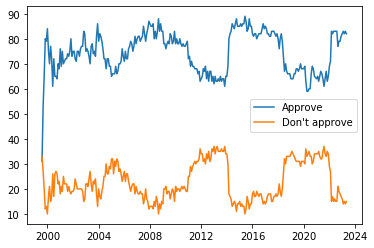

In [13]:
# label – чтобы назвать каждый график и отразить это в легенде

plt.plot(df["date"], df["yes"], label = "Approve")
plt.plot(df["date"], df["no"], label = "Don't approve")
plt.legend()

Отлично! График готов, похож на аналогичный график на сайте Левада-Центра. Конечно, размер и масштаб у этого графика не очень подходящие, но это всегда можно исправить (см. материалы по визуализации [здесь](http://math-info.hse.ru/s22/d)).